In [1]:
import pandas as pd
import json
import numpy as np
import statsmodels.api as sms
import matplotlib.pyplot as plt
from scipy import stats
import tqdm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.model_selection import TimeSeriesSplit
from pylab import rcParams
from sklearn.metrics import mean_absolute_error as mae
import warnings
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

# Введение. Сложность используемого датасета

Мною был взят dataset с платформы Kaggle https://www.kaggle.com/devinanzelmo/dota-2-matches?select=objectives.csv

Этот датасет содержит таблицы данных по матчам рейтинговых игр по компьютерной
многопользовательской командной игре Dota 2. Датасет взят при помощи собранной статистики самой игрой и взят с официальных
сайтов ,связанных с дотой, после чего был залит на Kaggle. 

Данные собраны за 2 недели 2015 года по 50000 матчам, проходящим тогда в реальном времени в рейтинговом режиме

Мне очень хотелось в качестве статистического мини-проекта выбрать тему, которая мне была бы наиболее 
интересна. Я понимаю заранее, что по этому датасету и этим данным очень сложно применить временные ряды 
и прогноз по ним. 

К сожалению, чего то действительно стоящего касательно обработки и предикшна при помощи временных рядов придумать не удалось.

Была идея использовать id-шники матчей или конкретных игроков. И при этом была даже попытка предсказать соотношение
KDA ( KDA = (kills + assists )/ deaths) для игроков или же GPM ( gold_per_minuts) на последующие матчи, 
основываясь на данных, собранных по предыдущим матчам.

Например, была идея рассмотреть КДА самых скилловых игроков из таблицы скилла рейтинга игроков. 
И в целом, предсказать, например, исходя из тех героев, на которых играет обычно игрок - что же он выдаст в следующей игре 
по своему перфомансу?

Или же, например, скорее задача регрессии: основываясь на заработанном золоте или gpm предсказать 
сколько зарабатает игрок в следующей игре  или с какой скоростью будет это золото зарабатывать? 

Однако, проблема в том, что игры между собой, несмотря на то, что допускают слабую зависимость - в большинстве своём
не влияют одна на другую и являются независимыми. Поэтому идею реализации временных рядов даже при желании не удалось
получить.

Я понимаю, что не используя в проекте возможность работать с временными рядами я гарантированно заранее теряю некоторое
количество баллов, однако мне очень хотелось не только закрепить овладенные знания при помощи этого проекта, 
но и исследовать именно ту область, которая мне действительно интересна, и касательно которой я давно строил 
гипотезы и догадки и наконец то смог прикладно проверить некоторые из них.

# Первичный анализ данных

Цель моего проекта - изучить различные взаимосвязи между данными, собранными по играм Доты.

Я хочу проверить некоторые мои гипотезы и предположения, касательно взаимосвязи регионов, игроков, игр и т д.

Также хочется понять, влияет ли присутствие какого-то определённого героя в игре на продолжительность этой игры и т д.

Все проделанные исследования будут подробно приведены ниже

К вопросу о данных. Данные содержат таблицы:

### 1) hero_names.csv - Датасет с id-шниками героев

hero_id - айдишник

localized_name - название героя

### 2) item_ids.csv - Данные по id-шникам артефактов в игре

### 3) match.csv - Датасет с 50 к матчами, в котором содержиться вся основная информация.

По столбцам:

start_time - Unix timestamp of when the match began - это информация о начале матча в Unix time формате. Данный
формат нам ещё пригодится, когда мы будем использовать информацию о том, в каком патче эти матчи были сыграны

duration - The length of the match, in seconds since the match began. Длительность игры

tower_status_radiant, tower_status_dire, barracks_status_dire,barracks_status_radiant - это информация о состоянии 
башен и казарм, дропну эти колонки. Эта информация необходима в рамках более глубокого исследования, чем этот проект, поэтому не буду её использовать. Сориентируюсь не на то, когда и как были разрушены казармы и башни каждой из команд, 
а на других признаках, в основном - на том, какая команда победила

first_blood_time - The time in seconds since the match began when first-blood occurred
Интересный признак, отвечащий, на какой секунде с начала игры была пролита первая кровь - то есть было сделано первое убийство.
Было бы интересно ещё увидеть, какой именно командой оно было сделано, но к сожалению, этой информацией мы не обладаем.

negative_votes и positive_votes - The number of thumbs-up and The number of thumbs-down the game has received by users.
Это количество положительных и отрицательных отзывов, оставленных игроками обеих команд после окончания 
игры,а также отзывы пользователей, которые смотрели эту игру в онлайне и могли оставить свои.

cluster - The server cluster the match was played upon. Used for downloading replays of matches. Can be translated to region using dota constants. Грубо говоря - это просто айдишник региона, в котором проходил данный матч

game_mode - режим игры. В данном датасете рассмотрен только режим игры = 22,а именно Ranked Matchmaking -
многопользовательский рейтинговый режим

### 4) patch_dates.csv - Это информация с датами патчей и версий игры на перид с конца  2010 года по середину 2016 года.

### 5) player_ratings - это датасет с аккаунтами игроков. Он содержит в себе собранную информацию об игроках по определённым id,  количеству сыгранных игр этими игроками и количеству побед. 

player_ratings - player_ratings contains match counts, win counts, and TrueSkill rating, calculated on 900k matches which occurred prior to other uploaded data.

trueskill ratings have two components, mu,
which can be interpreted as the skill, with higher value being better, and sigma which is the uncertainty of the rating.

Для каждого игрока определён средний скилл ( параметр, определяющий умение его игры)

Также, судя по всему, датасет содержит в себе account_id = 0, для которого собрано очень много игр.

Скорее всего, система отправила в этот id-шник все матчи игроков, id-шники которых она не смогла распознать

### 6) players.csv - players

Individual players are identified by account_id but there is an option to play anonymously and roughly one third of the account_id are not available. Anonymous users have the value of 0 for account_id. Contains totals for kills, deaths, denies, etc. Player action counts are available, and are indicated by variable names beginning with unit_order_.
Counts for reasons for acquiring or losing gold, and gaining experience, have prefixes gold_, and xp_.

Описание датасета players подтверждает мои догадки. Как и предполагалось мною выше, account_id = 0 -
это анонимные игроки, для которых система не смогла определить их id-шник.

### 7) test_labels и 8) test_player

Рассмотрим ещё два дополнительных связанных между собой датасета,а именно test_labels и test_player.

7)test_labels: matchid and radiantwin(as integer 1 or 0)
    
8)test_player: full player and match table with heroid, playerslot, matchid, and accountid

Это два датасета, один из которых представляет собой 100 тысяч матчей для каждого из которых определено, какая
именно сторона radient или dire выиграла в матче.

Другой же даёт понимание, в каких матчах какого героя выбрали игроки и какие именно игроки участвовали в матче(по айдишникам)

### 9) cluster_regions.csv - Датасет с регионами

Всего регионов не так много, но в каждом из них может быть несколько кластеров, записанных через цифровые айдишники

# Предобработка данных

Теперь, помимо текстового описания наших датасетов, загрузим их и рассмотрим более наглядно.

Также, произведём некоторую предобработку, удалив ненужную в данном исследовании информацию

## 1) hero_names.csv

In [2]:
df_heroes = pd.read_csv('dota matches/hero_names.csv')
df_heroes

,name,hero_id,localized_name
0,npc_dota_hero_antimage,1,Anti-Mage
1,npc_dota_hero_axe,2,Axe
2,npc_dota_hero_bane,3,Bane
3,npc_dota_hero_bloodseeker,4,Bloodseeker
4,npc_dota_hero_crystal_maiden,5,Crystal Maiden
...,...,...,...
107,npc_dota_hero_terrorblade,109,Terrorblade
108,npc_dota_hero_phoenix,110,Phoenix
109,npc_dota_hero_oracle,111,Oracle
110,npc_dota_hero_winter_wyvern,112,Winter Wyvern


Колонку name дропну в силу того, что она не несёт никакой дополнительной информативности

In [3]:
df_heroes = df_heroes.drop(['name'], axis = 1 )
df_heroes

,hero_id,localized_name
0,1,Anti-Mage
1,2,Axe
2,3,Bane
3,4,Bloodseeker
4,5,Crystal Maiden
...,...,...
107,109,Terrorblade
108,110,Phoenix
109,111,Oracle
110,112,Winter Wyvern


Переименую localized_name в name для более удобной агрегации

In [4]:
df_heroes = df_heroes.rename(columns={'localized_name': 'name'})
df_heroes

,hero_id,name
0,1,Anti-Mage
1,2,Axe
2,3,Bane
3,4,Bloodseeker
4,5,Crystal Maiden
...,...,...
107,109,Terrorblade
108,110,Phoenix
109,111,Oracle
110,112,Winter Wyvern


### 2) item_ids.csv

Не уверен, что это пригодится в дальнейшем, однако считывание для полноты данных произведу

In [5]:
df_item_ids = pd.read_csv('dota matches/item_ids.csv')
df_item_ids

,item_id,item_name
0,1,blink
1,2,blades_of_attack
2,3,broadsword
3,4,chainmail
4,5,claymore
...,...,...
184,1023,river_painter3
185,1024,river_painter4
186,1025,river_painter5
187,1026,river_painter6


### 3)matches: contains top level information about each match

In [6]:
df_matches = pd.read_csv('dota matches/match.csv')
df_matches

,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster
0,0,1446750112,2375,1982,4,3,63,1,22,True,0,1,155
1,1,1446753078,2582,0,1846,63,0,221,22,False,0,2,154
2,2,1446764586,2716,256,1972,63,48,190,22,False,0,0,132
3,3,1446765723,3085,4,1924,51,3,40,22,False,0,0,191
4,4,1446796385,1887,2047,0,0,63,58,22,True,0,0,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,1447829192,3025,1824,0,0,63,117,22,True,0,0,111
49996,49996,1447829181,1451,1982,384,48,63,147,22,True,0,0,204
49997,49997,1447829197,2672,1830,0,0,63,130,22,True,0,0,111
49998,49998,1447829189,2211,1982,4,3,63,645,22,True,0,0,151


Удалю все ненужные для дальнейшего исследования столбцы:

In [7]:
df_matches = df_matches.drop(['tower_status_radiant'], axis = 1 )
df_matches = df_matches.drop(['tower_status_dire'], axis = 1 )
df_matches = df_matches.drop(['barracks_status_dire'], axis = 1 )
df_matches = df_matches.drop(['barracks_status_radiant'], axis = 1 )
df_matches = df_matches.drop(['game_mode'], axis = 1 )

In [8]:
df_matches

,match_id,start_time,duration,first_blood_time,radiant_win,negative_votes,positive_votes,cluster
0,0,1446750112,2375,1,True,0,1,155
1,1,1446753078,2582,221,False,0,2,154
2,2,1446764586,2716,190,False,0,0,132
3,3,1446765723,3085,40,False,0,0,191
4,4,1446796385,1887,58,True,0,0,156
...,...,...,...,...,...,...,...,...
49995,49995,1447829192,3025,117,True,0,0,111
49996,49996,1447829181,1451,147,True,0,0,204
49997,49997,1447829197,2672,130,True,0,0,111
49998,49998,1447829189,2211,645,True,0,0,151


### 4)patch_dates.csv

In [9]:
df_patch_dates = pd.read_csv('dota matches/patch_dates.csv')
df_patch_dates

,patch_date,name
0,2010-12-24T00:00:00Z,6.70
1,2011-01-21T00:00:00Z,6.71
2,2011-04-27T00:00:00Z,6.72
3,2011-12-24T00:00:00Z,6.73
4,2012-03-10T00:00:00Z,6.74
5,2012-09-30T00:00:00Z,6.75
6,2012-10-21T00:00:00Z,6.76
7,2012-12-15T00:00:00Z,6.77
8,2013-05-30T00:00:00Z,6.78
9,2013-11-24T00:00:00Z,6.79


Была идея рассмотреть игры в датасете в разных патчах, в надежде найти какое-то изменение меты, изменение длительности игры
в связи со внутренними обновлениями, внесёнными в игровой процесс.

In [10]:
df_matches.start_time.min()

1446750112

In [11]:
df_matches.start_time.max()

1447829215

Однако, давайте рассмотрим колонку df_matches.start_time.

Очевидно, что в данном датасете матчи идут последовательно и матч с id = 0 - самый первый по дате, а матч с id = 49999 - последний

Переведём это всё в unix time формат:
    
1446750112 = Thu, 05 Nov 2015 19:01:52 GMT
        
1447829215 = Wed, 18 Nov 2015 06:46:55 GMT
    
Как мы видим, все игры были сыграны в рамках одного патча,а именно патча 6.85, который был выпущен
2015-09-24 и  закончился 2015-12-16.

В силу чего, сравнение игр в зависимости от патчей невозможно и эту идею пришлось опустить

### 5) player_ratings - это датасет с аккаунтами игроков. 

In [12]:
df_player_ratings = pd.read_csv('dota matches/player_ratings.csv')
df_player_ratings

,account_id,total_wins,total_matches,trueskill_mu,trueskill_sigma
0,236579,14,24,27.868035,5.212361
1,-343,1,1,26.544163,8.065475
2,-1217,1,1,26.521103,8.114989
3,-1227,1,1,27.248025,8.092217
4,-1284,0,1,22.931016,8.092224
...,...,...,...,...,...
834221,-298722891,1,1,27.643145,8.013786
834222,106173,0,1,23.069381,7.998792
834223,312076,1,1,28.217084,7.889176
834224,-299193988,0,2,22.406145,7.851303


Исключим анонимных игроков и будем работать с датасетом только с определёнными в нём айдишниками

In [13]:
df_playerMMR0 = df_player_ratings[df_player_ratings.account_id >= 0]
df_playerMMR0

,account_id,total_wins,total_matches,trueskill_mu,trueskill_sigma
0,236579,14,24,27.868035,5.212361
5,308663,1,1,26.761476,8.108880
6,79749,21,40,30.553417,3.868734
9,26500,26,50,27.943621,4.049005
11,137046,46,89,26.025998,2.865184
...,...,...,...,...,...
834218,215153,0,1,24.004033,8.150131
834219,272061,0,1,22.214808,8.010834
834222,106173,0,1,23.069381,7.998792
834223,312076,1,1,28.217084,7.889176


Отсортируем по account_id

In [14]:
df_playerMMR0 = df_playerMMR0.sort_values(by=['account_id'], ascending=[True])
df_playerMMR0

,account_id,total_wins,total_matches,trueskill_mu,trueskill_sigma
834225,0,1608398,3315071,25.000000,8.333333
704459,1,14,24,26.232905,4.854238
808554,2,5,8,27.614505,6.550771
407877,3,5,16,20.221006,5.961434
269990,4,11,20,26.773302,5.322094
...,...,...,...,...,...
340498,330509,7,14,26.986934,5.739053
194019,330510,39,73,27.018324,3.302383
162229,330511,2,3,25.990246,7.555608
4107,330512,2,2,28.353306,7.765557


Избавимся от анонимных аккаунтов, удалив из данных account_id = 0 и будем работать только с верифицированными данными

In [15]:
df_playerMMR = df_player_ratings[df_player_ratings.account_id >0]
df_playerMMR

,account_id,total_wins,total_matches,trueskill_mu,trueskill_sigma
0,236579,14,24,27.868035,5.212361
5,308663,1,1,26.761476,8.108880
6,79749,21,40,30.553417,3.868734
9,26500,26,50,27.943621,4.049005
11,137046,46,89,26.025998,2.865184
...,...,...,...,...,...
834215,136022,1,2,24.065296,7.614250
834218,215153,0,1,24.004033,8.150131
834219,272061,0,1,22.214808,8.010834
834222,106173,0,1,23.069381,7.998792


### 6) players.csv - players

In [16]:
df_players = pd.read_csv('dota matches/players.csv')
df_players

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,...,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue
0,0,0,86,0,3261,10960,347,362,9,3,...,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,51,1,2954,17760,494,659,13,3,...,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,83,2,110,12195,350,385,0,4,...,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,11,3,1179,22505,599,605,8,4,...,1.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,3,67,4,3307,23825,613,762,20,3,...,3.0,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,49999,0,100,128,2718,17735,468,626,16,9,...,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
499996,49999,0,9,129,3755,20815,507,607,12,6,...,1.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN
499997,49999,0,90,130,1059,16225,371,404,5,3,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
499998,49999,0,73,131,3165,31015,780,703,8,6,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
pd.set_option('display.max_columns', 100)

Содержит огромное количество столбцов,придётся дропнуть все ненужные для удобной работы и дальнейшего исследования.

Во многих столбцах слишком мало глобальной информативности

Удалим информацию о предметах - эта информация требует более глубокого исследования

In [18]:
df_players = df_players.drop(['item_0'], axis = 1 )
df_players = df_players.drop(['item_1'], axis = 1 )
df_players = df_players.drop(['item_2'], axis = 1 )
df_players = df_players.drop(['item_3'], axis = 1 )
df_players = df_players.drop(['item_4'], axis = 1 )
df_players = df_players.drop(['item_5'], axis = 1 )
df_players

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,level,leaver_status,xp_hero,xp_creep,xp_roshan,xp_other,gold_other,gold_death,gold_buyback,gold_abandon,gold_sell,gold_destroying_structure,gold_killing_heros,gold_killing_creeps,gold_killing_roshan,gold_killing_couriers,unit_order_none,unit_order_move_to_position,unit_order_move_to_target,unit_order_attack_move,unit_order_attack_target,unit_order_cast_position,unit_order_cast_target,unit_order_cast_target_tree,unit_order_cast_no_target,unit_order_cast_toggle,unit_order_hold_position,unit_order_train_ability,unit_order_drop_item,unit_order_give_item,unit_order_pickup_item,unit_order_pickup_rune,unit_order_purchase_item,unit_order_sell_item,unit_order_disassemble_item,unit_order_move_item,unit_order_cast_toggle_auto,unit_order_stop,unit_order_taunt,unit_order_buyback,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue
0,0,0,86,0,3261,10960,347,362,9,3,18,1,30,76.7356,8690,218,143,16,0,8840.0,5440.0,NaN,83.0,50.0,-957.0,NaN,NaN,212.0,3120.0,5145.0,1087.0,400.0,NaN,NaN,4070.0,1.0,25.0,416.0,51.0,144.0,3.0,71.0,NaN,188.0,16.0,NaN,NaN,NaN,2.0,35.0,2.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,51,1,2954,17760,494,659,13,3,18,9,109,87.4164,23747,0,423,22,0,14331.0,8440.0,2683.0,671.0,395.0,-1137.0,NaN,NaN,1650.0,3299.0,6676.0,4317.0,937.0,NaN,NaN,5894.0,214.0,165.0,1031.0,98.0,39.0,4.0,439.0,NaN,346.0,22.0,NaN,NaN,12.0,52.0,30.0,4.0,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,83,2,110,12195,350,385,0,4,15,1,58,None,4217,1595,399,17,0,6692.0,8112.0,NaN,453.0,259.0,-1436.0,-1015.0,NaN,NaN,3142.0,2418.0,3697.0,400.0,NaN,NaN,7053.0,3.0,132.0,645.0,36.0,160.0,20.0,373.0,NaN,643.0,17.0,5.0,NaN,7.0,8.0,28.0,NaN,1.0,18.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,11,3,1179,22505,599,605,8,4,19,6,271,None,14832,2714,6055,21,0,8583.0,14230.0,894.0,293.0,100.0,-2156.0,NaN,NaN,938.0,4714.0,4104.0,10432.0,400.0,NaN,NaN,4712.0,133.0,163.0,690.0,9.0,15.0,7.0,406.0,NaN,150.0,21.0,NaN,NaN,1.0,9.0,45.0,7.0,NaN,14.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,3,67,4,3307,23825,613,762,20,3,17,13,245,None,33740,243,1833,24,0,15814.0,14325.0,NaN,62.0,NaN,-1437.0,-1056.0,NaN,4194.0,3217.0,7467.0,9220.0,400.0,NaN,NaN,3853.0,7.0,7.0,1173.0,31.0,84.0,8.0,198.0,NaN,111.0,23.0,1.0,NaN,NaN,2.0,44.0,6.0,NaN,13.0,NaN,NaN,NaN,1.0,3.0,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,49999,0,100,128,2718,17735,468,626,16,9,16,2,70,54.4912,22127,0,1227,23,0,21496.0,6025.0,596.0,1007.0,528.0,-4131.0,NaN,NaN,237.0,3860.0,9377.0,2940.0,400.0,NaN,NaN,4042.0,79.0,192.0,423.0,81.0,38.0,5.0,281.0,NaN,NaN,22.0,NaN,NaN,2.0,21.0,32.0,3.0,NaN,9.0,21.0,169.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
499996,49999,0,9,129,3755,20815,507,607,12,6,11,7,115,43.0999,12381,0,2269,23,0,16360.0,9653.0,1490.0,740.0,329.0,-2274.0,NaN,NaN,1587.0,4945.0,8292.0,4346.0,857.0,175.0,NaN,4412.0,NaN,89.0,625.0,75.0,NaN,4.0,162.0,2.0,224.0,21.0,NaN,NaN,NaN,9.0,42.0,7.0,NaN,13.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN
499997,49999,0,90,130,1059,16225,371,404,5,3,11,2,92,18.1353,7050,872,87,18,0,8205.0,10012.0,NaN,600.0,303.0,-1287.0,NaN,NaN,NaN,3860.0,4027.0,3833.0,400.0,175.0,NaN,4824.0,146.0,53.0,266.0,135.0,153.0,7.0,49.0,NaN,1.0,18.0,NaN,NaN,1.0,22.0,39.0,NaN,NaN,5.0,NaN,108.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
499998,49999,0,73,131,3165,31015,780,703,8,6,

In [19]:
df_players = df_players.drop(['leaver_status'], axis = 1 )
df_players = df_players.drop(['xp_hero'], axis = 1 )
df_players = df_players.drop(['xp_creep'], axis = 1 )
df_players = df_players.drop(['xp_roshan'], axis = 1 )
df_players = df_players.drop(['xp_other'], axis = 1 )
df_players = df_players.drop(['gold_other'], axis = 1 )
df_players = df_players.drop(['gold_death'], axis = 1 )
df_players = df_players.drop(['gold_buyback'], axis = 1 )
df_players = df_players.drop(['gold_abandon'], axis = 1 )
df_players = df_players.drop(['gold_sell'], axis = 1 )
df_players = df_players.drop(['gold_destroying_structure'], axis = 1 )
df_players = df_players.drop(['gold_killing_heros'], axis = 1 )
df_players = df_players.drop(['gold_killing_creeps'], axis = 1 )
df_players = df_players.drop(['gold_killing_roshan'], axis = 1 )
df_players = df_players.drop(['gold_killing_couriers'], axis = 1 )
df_players = df_players.drop(['unit_order_none'], axis = 1 )
df_players = df_players.drop(['unit_order_move_to_position'], axis = 1 )
df_players = df_players.drop(['unit_order_move_to_target'], axis = 1 )
df_players = df_players.drop(['unit_order_attack_move'], axis = 1 )
df_players = df_players.drop(['unit_order_attack_target'], axis = 1 )
df_players = df_players.drop(['unit_order_cast_position'], axis = 1 )
df_players = df_players.drop(['unit_order_cast_target'], axis = 1 )
df_players = df_players.drop(['unit_order_cast_target_tree'], axis = 1 )
df_players = df_players.drop(['unit_order_cast_no_target'], axis = 1 )
df_players = df_players.drop(['unit_order_cast_toggle'], axis = 1 )
df_players = df_players.drop(['unit_order_hold_position'], axis = 1 )
df_players = df_players.drop(['unit_order_train_ability'], axis = 1 )
df_players = df_players.drop(['unit_order_drop_item'], axis = 1 )
df_players = df_players.drop(['unit_order_give_item'], axis = 1 )
df_players = df_players.drop(['unit_order_pickup_item'], axis = 1 )
df_players = df_players.drop(['unit_order_pickup_rune'], axis = 1 )
df_players = df_players.drop(['unit_order_purchase_item'], axis = 1 )
df_players = df_players.drop(['unit_order_sell_item'], axis = 1 )
df_players = df_players.drop(['unit_order_disassemble_item'], axis = 1 )
df_players = df_players.drop(['unit_order_move_item'], axis = 1 )
df_players = df_players.drop(['unit_order_cast_toggle_auto'], axis = 1 )
df_players = df_players.drop(['unit_order_stop'], axis = 1 )
df_players = df_players.drop(['unit_order_taunt'], axis = 1 )
df_players = df_players.drop(['unit_order_buyback'], axis = 1 )
df_players = df_players.drop(['unit_order_glyph'], axis = 1 )
df_players = df_players.drop(['unit_order_eject_item_from_stash'], axis = 1 )
df_players = df_players.drop(['unit_order_cast_rune'], axis = 1 )
df_players = df_players.drop(['unit_order_ping_ability'], axis = 1 )
df_players = df_players.drop(['unit_order_move_to_direction'], axis = 1 )
df_players = df_players.drop(['unit_order_patrol'], axis = 1 )
df_players = df_players.drop(['unit_order_vector_target_position'], axis = 1 )
df_players = df_players.drop(['unit_order_radar'], axis = 1 )
df_players = df_players.drop(['unit_order_set_item_combine_lock'], axis = 1 )
df_players = df_players.drop(['unit_order_continue'], axis = 1 )
df_players

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,level
0,0,0,86,0,3261,10960,347,362,9,3,18,1,30,76.7356,8690,218,143,16
1,0,1,51,1,2954,17760,494,659,13,3,18,9,109,87.4164,23747,0,423,22
2,0,0,83,2,110,12195,350,385,0,4,15,1,58,None,4217,1595,399,17
3,0,2,11,3,1179,22505,599,605,8,4,19,6,271,None,14832,2714,6055,21
4,0,3,67,4,3307,23825,613,762,20,3,17,13,245,None,33740,243,1833,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,49999,0,100,128,2718,17735,468,626,16,9,16,2,70,54.4912,22127,0,1227,23
499996,49999,0,9,129,3755,20815,507,607,12,6,11,7,115,43.0999,12381,0,2269,23
499997,49999,0,90,130,1059,16225,371,404,5,3,11,2,92,18.1353,7050,872,87,18
499998,49999,0,73,131,3165,31015,780,703,8,6,17,6,306,64.3631,16474,0,2851,25


Путем многочисленных дропов мы оставили только ту информацию, которая может нам в дальнейшем пригодиться

### 7)test_labels:

In [20]:
df_test_labels = pd.read_csv('dota matches/test_labels.csv')
df_test_labels

,match_id,radiant_win
0,50000,0
1,50001,1
2,50002,0
3,50003,1
4,50004,0
...,...,...
99995,149995,1
99996,149996,1
99997,149997,1
99998,149998,1


### 8)test_player

In [21]:
df_test_player = pd.read_csv('dota matches/test_player.csv')
df_test_player

,match_id,account_id,hero_id,player_slot
0,50000,117784,96,0
1,50000,158361,84,1
2,50000,158362,46,2
3,50000,137970,85,3
4,50000,1090,39,4
...,...,...,...,...
999995,149999,142244,74,128
999996,149999,186948,8,129
999997,149999,128992,50,130
999998,149999,133430,55,131


Здесь есть метка player_slot. Для данных исследований она не понадобится, поэтому я дропну эту колонку из нашего датасета

In [22]:
df_test_player = df_test_player.drop(['player_slot'], axis = 1)
df_test_player

,match_id,account_id,hero_id
0,50000,117784,96
1,50000,158361,84
2,50000,158362,46
3,50000,137970,85
4,50000,1090,39
...,...,...,...
999995,149999,142244,74
999996,149999,186948,8
999997,149999,128992,50
999998,149999,133430,55


### 9) cluster_regions

In [23]:
df_regions = pd.read_csv('dota matches/cluster_regions.csv')
df_regions

,cluster,region
0,111,US WEST
1,112,US WEST
2,113,US WEST
3,121,US EAST
4,122,US EAST
5,123,US EAST
6,124,US EAST
7,131,EUROPE
8,132,EUROPE
9,133,EUROPE


# Визуальный анализ данных

Сделаем несколько важных визуализаций наших данных, представляющих собой по сути отдельное исследование

Для начала, визуализируем среди 50 тысяч матчей, которые мы имеем, каких героев пикали игроки чаще всего.

То есть, посмотрим, сколько раз среди 50 тысяч матчей герой встречался в игре

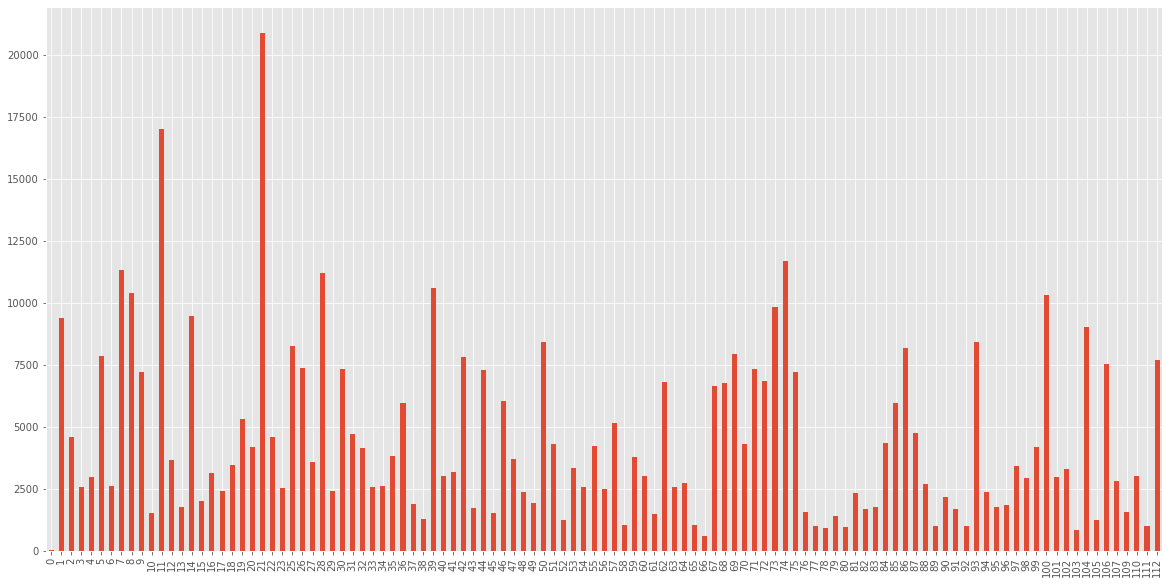

In [24]:
fig = plt.figure(figsize= (20,10))
df_players['hero_id'].value_counts(sort = False).plot.bar()

Как мы видим, распределение довольно-таки неравномерное.

Теперь, выведем эту гистограмму по убыванию пикабельности

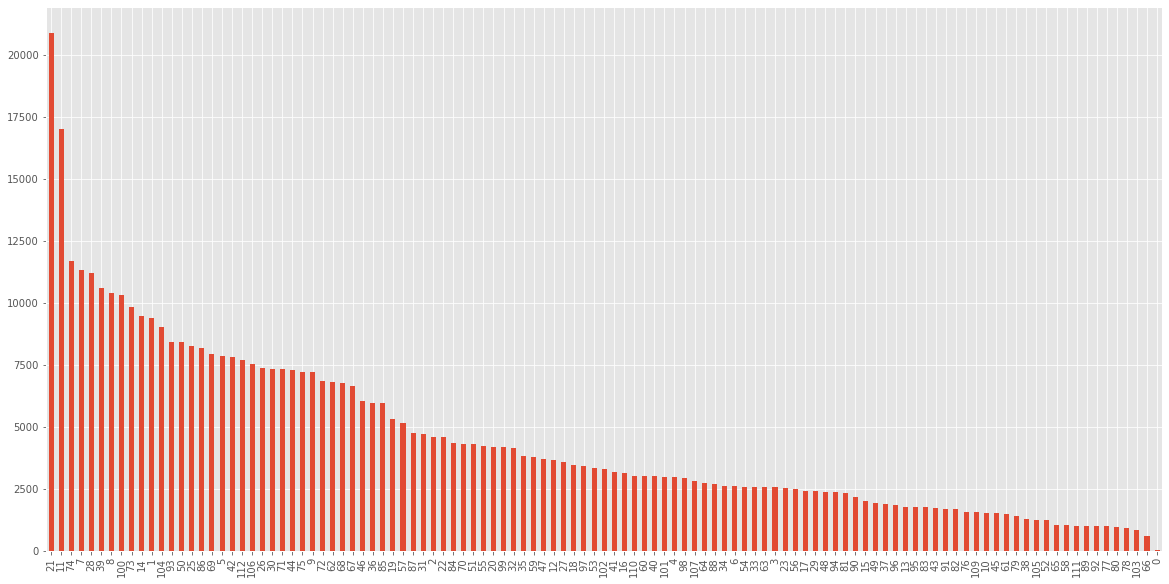

In [25]:
fig = plt.figure(figsize= (20,10))
df_players['hero_id'].value_counts().plot.bar()

Выведем теперь топ 10 самых пикабельных персонажей на момент этих 50 тысяч игр в ноябре 2015 года

In [28]:
df_top10pick_heroes = df_heroes[(df_heroes.hero_id == 21) | (df_heroes.hero_id == 11) | (df_heroes.hero_id == 74) |
         (df_heroes.hero_id == 7) | (df_heroes.hero_id == 28) | (df_heroes.hero_id == 39) | 
                               (df_heroes.hero_id == 8) | (df_heroes.hero_id == 100) | (df_heroes.hero_id == 73)
                               | (df_heroes.hero_id == 14)]

In [29]:
df_top10pick_heroes['toppick'] = [4, 7, 2, 10, 1, 5, 6, 9, 3, 8]

In [30]:
df_top10pick_heroes = df_top10pick_heroes.sort_values(by = ['toppick'])
df_top10pick_heroes

,hero_id,name,toppick
20,21,Windranger,1
10,11,Shadow Fiend,2
72,74,Invoker,3
6,7,Earthshaker,4
26,28,Slardar,5
37,39,Queen of Pain,6
7,8,Juggernaut,7
98,100,Tusk,8
71,73,Alchemist,9
13,14,Pudge,10


Как мы видим, мы получили 10 самых популярных персонажей среди игроков на тот момент.

А что если рассмотреть наоборот 10 САМЫХ НЕПОПУЛЯРНЫХ персонажей? Сделаем же это

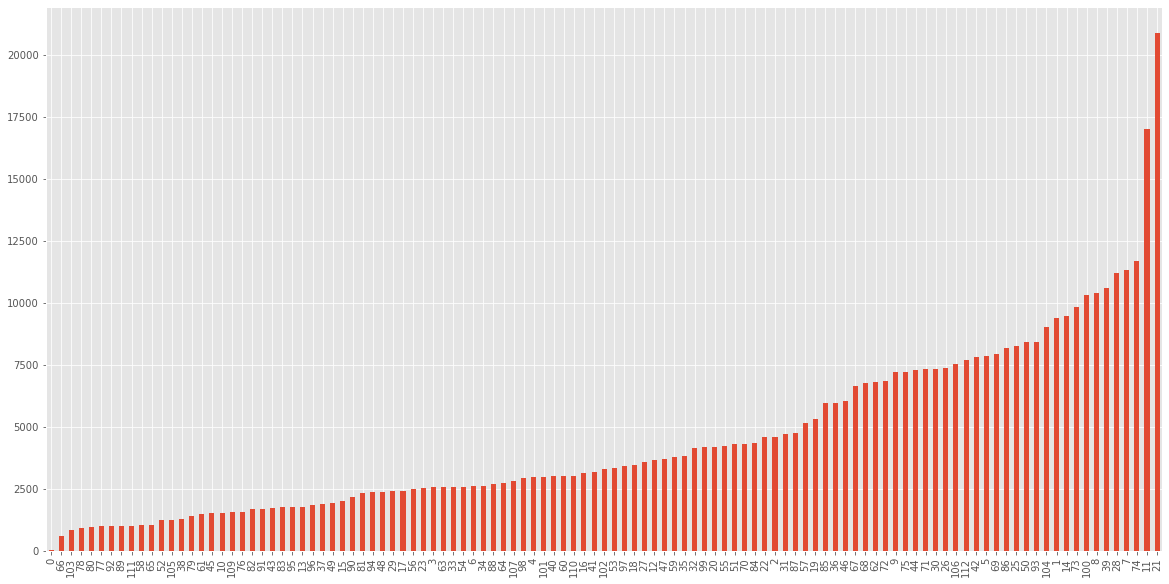

In [31]:
fig = plt.figure(figsize= (20,10))
df_players['hero_id'].value_counts(ascending = True).plot.bar()

In [32]:
df_antitop10pick_heroes = df_heroes[(df_heroes.hero_id == 66) | (df_heroes.hero_id == 103) | (df_heroes.hero_id == 78) |
         (df_heroes.hero_id == 80) | (df_heroes.hero_id == 77) | (df_heroes.hero_id == 92) | 
                               (df_heroes.hero_id == 89) | (df_heroes.hero_id == 111) | (df_heroes.hero_id == 58)
                               | (df_heroes.hero_id == 65)]

In [33]:
df_antitop10pick_heroes['toppick'] = [9,10,1,5,3,4,7,6,2,8]
df_antitop10pick_heroes.sort_values(by = ['toppick'])
df_antitop10pick_heroes

,hero_id,name,toppick
56,58,Enchantress,9
63,65,Batrider,10
64,66,Chen,1
75,77,Lycan,5
76,78,Brewmaster,3
78,80,Lone Druid,4
87,89,Naga Siren,7
90,92,Visage,6
101,103,Elder Titan,2
109,111,Oracle,8


Как мы видим, мы получили ТОП 10 самых непопулярных и менее играбельных персонажей на тот момент в мете 2015 года

Но что, если эта статистика за 50 тысяч матчей непоказательная ? Ведь помимо датасета с 50 тысячами матчей
 у нас же есть ещё датасеты df_test_player и df_test_labels, которые содержат ещё 100 тысяч матчей.
    
Там поменьше информации в целом, но этой информации вполне достаточно, чтобы сделать выводы о рейтинге пикабельности
 и антипикабельности героев и сравнить - а будут ли похожие результаты с топами, полученными из прошлых 50к матчей?
    Проверим это

In [34]:
df_test_player

,match_id,account_id,hero_id
0,50000,117784,96
1,50000,158361,84
2,50000,158362,46
3,50000,137970,85
4,50000,1090,39
...,...,...,...
999995,149999,142244,74
999996,149999,186948,8
999997,149999,128992,50
999998,149999,133430,55


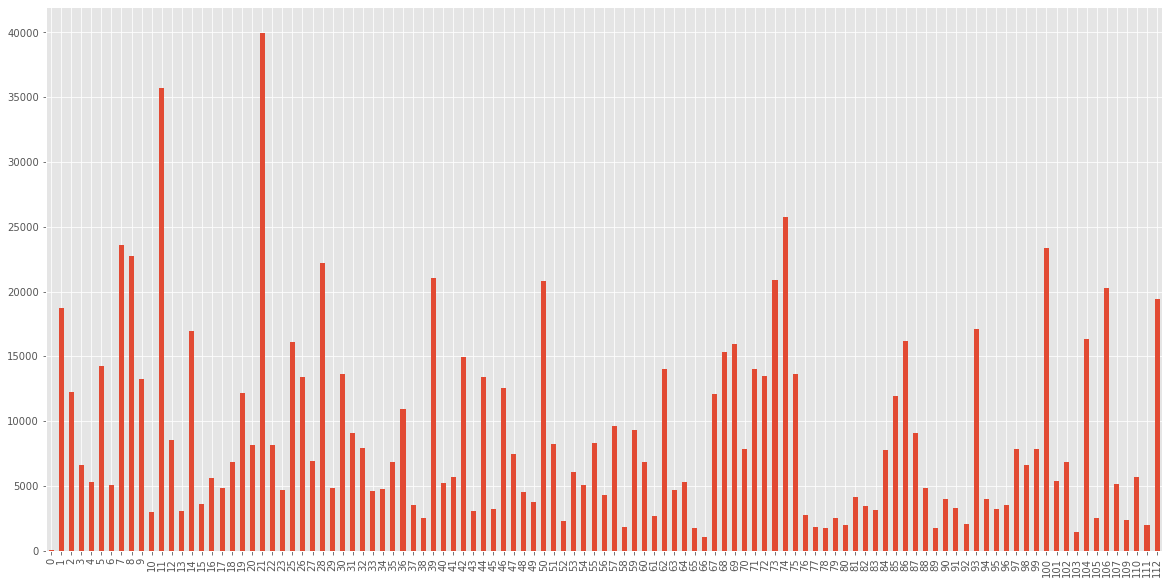

In [35]:
fig = plt.figure(figsize= (20,10))
df_test_player['hero_id'].value_counts(sort = False).plot.bar()

Общая визуализация будет выглядеть так, но теперь, отсортируем по убыванию и получим:

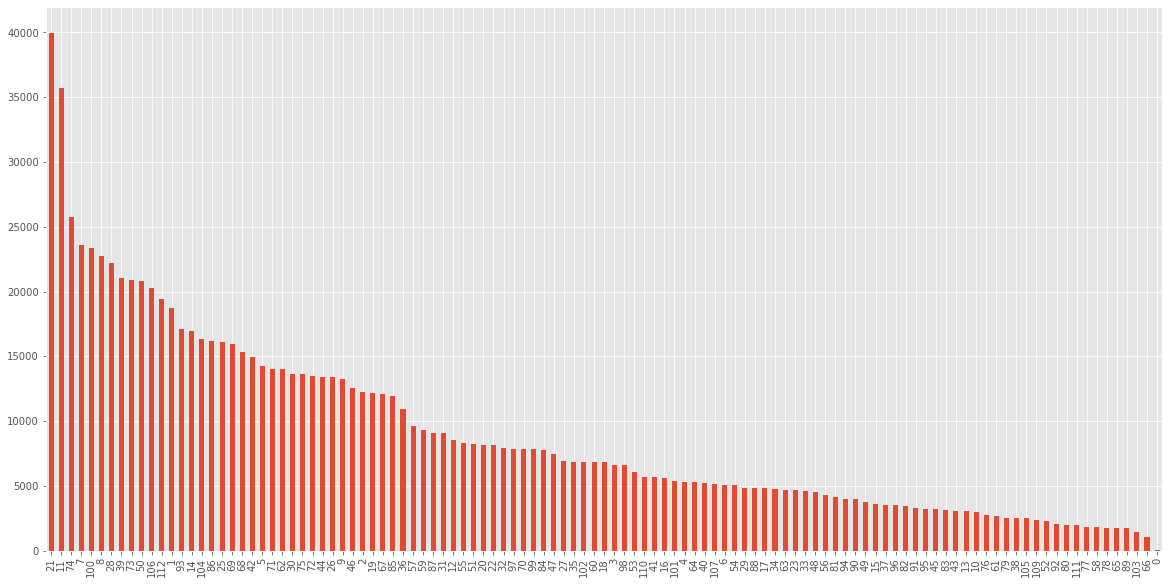

In [36]:
fig = plt.figure(figsize= (20,10))
df_test_player['hero_id'].value_counts().plot.bar()

Найдём теперь среди этих 100 тысяч матчей самых популярных героев среди игроков

In [37]:
df_top10pick_heroes2 = df_heroes[(df_heroes.hero_id == 21) | (df_heroes.hero_id == 11) | (df_heroes.hero_id == 74) |
         (df_heroes.hero_id == 7) | (df_heroes.hero_id == 100) | (df_heroes.hero_id == 8) | 
                               (df_heroes.hero_id == 28) | (df_heroes.hero_id == 39) | (df_heroes.hero_id == 73)
                               | (df_heroes.hero_id == 50)]

In [38]:
df_top10pick_heroes2['toppick'] = [4,6,2,1,7,8,10,9,3,5]
df_top10pick_heroes2 = df_top10pick_heroes2.sort_values(by = ['toppick'])
df_top10pick_heroes2

,hero_id,name,toppick
20,21,Windranger,1
10,11,Shadow Fiend,2
72,74,Invoker,3
6,7,Earthshaker,4
98,100,Tusk,5
7,8,Juggernaut,6
26,28,Slardar,7
37,39,Queen of Pain,8
71,73,Alchemist,9
48,50,Dazzle,10


Сравним полученные результаты:

In [39]:
df_top10pick_heroes

,hero_id,name,toppick
20,21,Windranger,1
10,11,Shadow Fiend,2
72,74,Invoker,3
6,7,Earthshaker,4
26,28,Slardar,5
37,39,Queen of Pain,6
7,8,Juggernaut,7
98,100,Tusk,8
71,73,Alchemist,9
13,14,Pudge,10


In [40]:
df_top10pick_heroes2

,hero_id,name,toppick
20,21,Windranger,1
10,11,Shadow Fiend,2
72,74,Invoker,3
6,7,Earthshaker,4
98,100,Tusk,5
7,8,Juggernaut,6
26,28,Slardar,7
37,39,Queen of Pain,8
71,73,Alchemist,9
48,50,Dazzle,10


Как мы видим, первые 4 героя - по прежнему остались такими же.
Но вот Slardar практически поменялся с Tusk-ом местами, что говорит в среднем об их одинаковой популярности

Также местами немного поменялись Alchemist, Queen of Pain и Juggernaut.

А вот Pudge-а сменил Dazzle, что довольно удивительно, ведь Dazzle - саппорт, и по идее не самый популярный герой.
Но в ноябре 2015 года, если судить по этим матчам, Dazzle мог посоревноваться в пикабельности с одним из самых популярных 
героев за всё время - с пуджом

Давайте проделаем такое же исследование теперь уже для 10 самых антипикабельных героев и также сравним

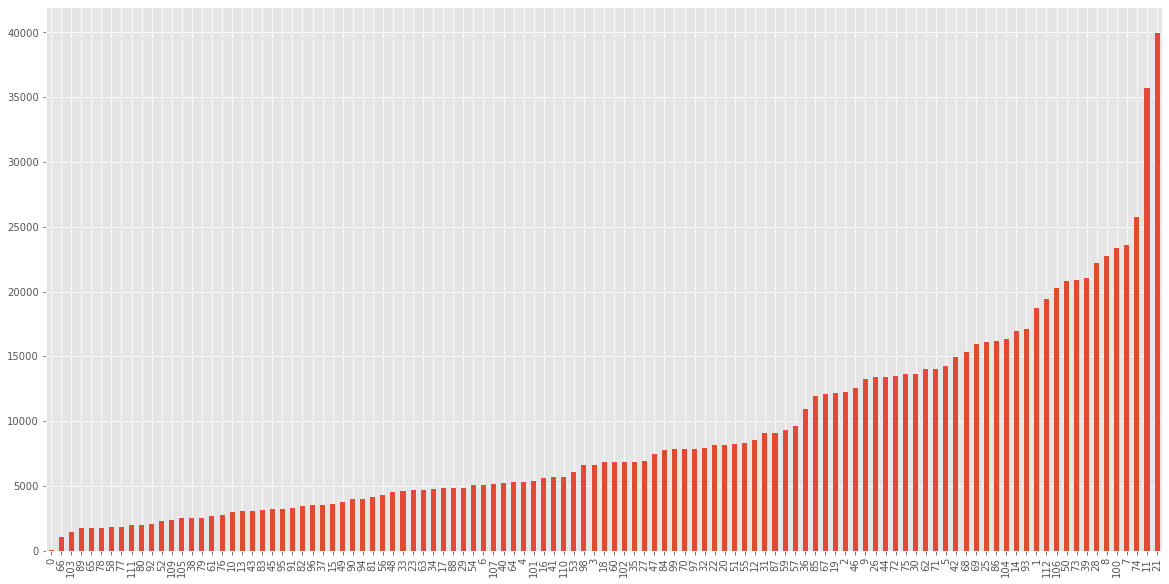

In [41]:
fig = plt.figure(figsize= (20,10))
df_test_player['hero_id'].value_counts(ascending = True).plot.bar()

In [42]:
df_antitop10pick_heroes2 = df_heroes[(df_heroes.hero_id == 66) | (df_heroes.hero_id == 103) | (df_heroes.hero_id == 89) |
         (df_heroes.hero_id == 65) | (df_heroes.hero_id == 78) | (df_heroes.hero_id == 58) | 
                               (df_heroes.hero_id == 77) | (df_heroes.hero_id == 111) | (df_heroes.hero_id == 80)
                               | (df_heroes.hero_id == 92)]

In [43]:
df_antitop10pick_heroes2['toppick'] = [6,4,1,7,5,9,3,10,2,8]
df_antitop10pick_heroes2 = df_antitop10pick_heroes2.sort_values(by = ['toppick'])
df_antitop10pick_heroes2

,hero_id,name,toppick
64,66,Chen,1
101,103,Elder Titan,2
87,89,Naga Siren,3
63,65,Batrider,4
76,78,Brewmaster,5
56,58,Enchantress,6
75,77,Lycan,7
109,111,Oracle,8
78,80,Lone Druid,9
90,92,Visage,10


Также сравним результаты для объективности

In [44]:
df_antitop10pick_heroes

,hero_id,name,toppick
56,58,Enchantress,9
63,65,Batrider,10
64,66,Chen,1
75,77,Lycan,5
76,78,Brewmaster,3
78,80,Lone Druid,4
87,89,Naga Siren,7
90,92,Visage,6
101,103,Elder Titan,2
109,111,Oracle,8


In [45]:
df_antitop10pick_heroes2

,hero_id,name,toppick
64,66,Chen,1
101,103,Elder Titan,2
87,89,Naga Siren,3
63,65,Batrider,4
76,78,Brewmaster,5
56,58,Enchantress,6
75,77,Lycan,7
109,111,Oracle,8
78,80,Lone Druid,9
90,92,Visage,10


Как мы видим, все герои полностью совпадают - что говорит о том, что именно эти 10 героев наименее популярны.

Вне завимости от того, в каком порядке они находятся в топе, исследование показало, что их примерно одинаково 
мало берут в играх

Визуализируем, в каком регионе сыграно больше всего игр:

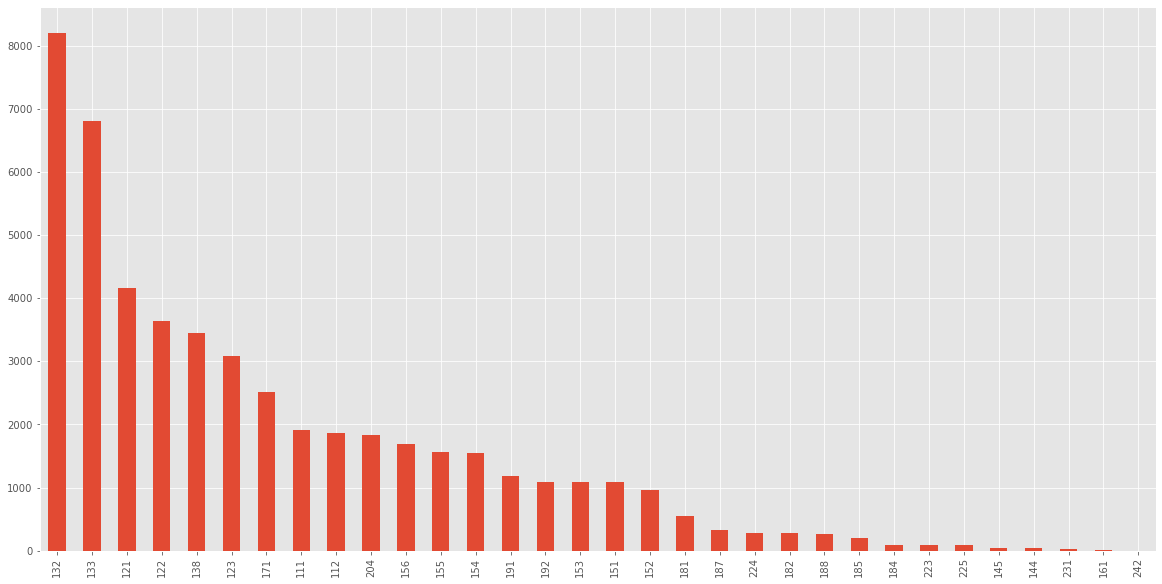

In [46]:
fig = plt.figure(figsize= (20,10))
df_matches['cluster'].value_counts().plot.bar()

In [47]:
df_regions

,cluster,region
0,111,US WEST
1,112,US WEST
2,113,US WEST
3,121,US EAST
4,122,US EAST
5,123,US EAST
6,124,US EAST
7,131,EUROPE
8,132,EUROPE
9,133,EUROPE


Как мы видим,наибольшее число матчей сделано было на серверах европы и америки - именно касательно этих
двух регионов мы и будем делать одно из дальнейших исследований и проверять гипотезу

Проверим ещё при помощи визуализации данных - какие герои умирали в датасете чаще всего,а также, за каких героев 
игроки делали наибольшее число убийств на карте

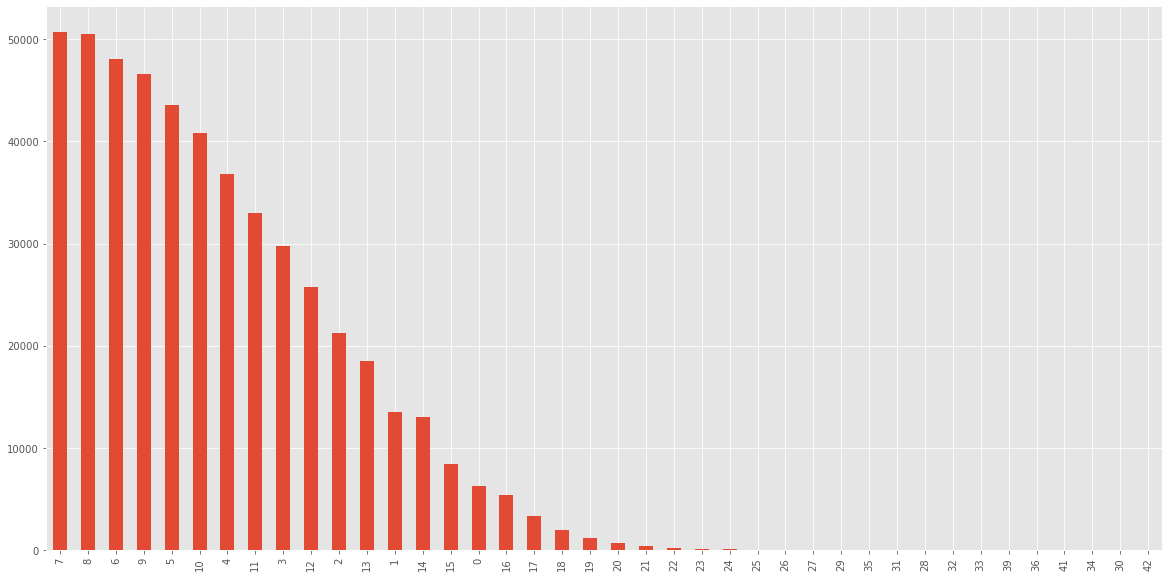

In [48]:
fig = plt.figure(figsize= (20,10))
df_players['deaths'].value_counts().plot.bar()

Возьмём только те данные, в которых у игроков не менее 20 смертей

In [49]:
df_deaths = df_players[df_players.deaths >= 20]
df_deaths

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,level
128,12,72,7,131,114,24685,362,403,4,27,9,1,134,89.807,9870,0,880,22
429,42,0,75,132,410,7240,192,217,1,20,7,2,49,None,6816,0,18,13
806,80,0,11,129,1811,26180,503,461,17,20,15,15,437,0.601865,23720,0,1144,25
815,81,463,27,128,265,7405,273,295,4,20,6,5,108,28.1649,7467,0,1435,15
1288,128,0,101,131,2374,17990,439,566,13,20,26,0,21,None,22465,0,0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498667,49866,100343,21,130,1595,3500,227,130,1,25,2,0,4,10.7307,476,0,0,7
499027,49902,0,39,130,78,14270,304,264,3,27,11,3,49,None,10080,0,20,15
499285,49928,35210,53,128,769,14535,412,356,3,20,25,0,293,None,13948,0,1668,18
499719,49971,0,59,132,484,3000,208,120,1,21,6,0,15,None,5280,0,41,7


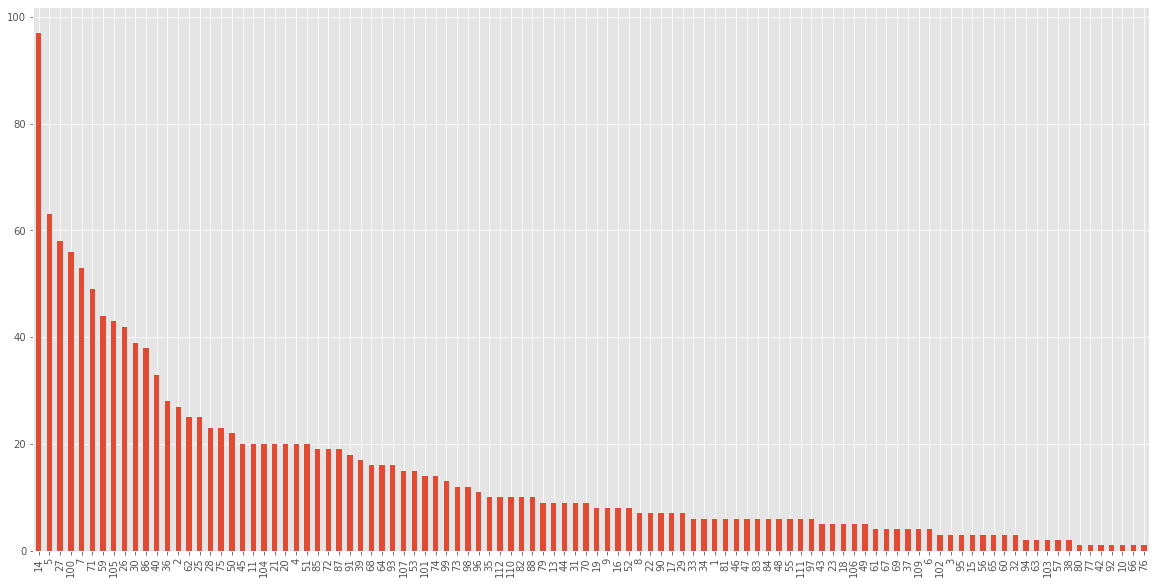

In [50]:
fig = plt.figure(figsize= (20,10))
df_deaths['hero_id'].value_counts().plot.bar()

Выведем топ-5 самых наиболее умираемых героев

In [51]:
df_top5death_heroes = df_heroes[(df_heroes.hero_id == 14) | (df_heroes.hero_id == 5) | (df_heroes.hero_id == 27) |
         (df_heroes.hero_id == 100) | (df_heroes.hero_id == 7)]

In [52]:
df_top5death_heroes['toppick'] = [2,5,1,3,4]
df_top5death_heroes = df_top5death_heroes.sort_values(by = ['toppick'])
df_top5death_heroes

,hero_id,name,toppick
13,14,Pudge,1
4,5,Crystal Maiden,2
25,27,Shadow Shaman,3
98,100,Tusk,4
6,7,Earthshaker,5


Как мы видим - наиболее часто умирали Crystal Maiden и Shadow Shaman, которые являются хрупкими саппортами,
а также Pudge,Tusk и Earthshaker, которые являются инициаторами и первые начинают драку. Вполне логично

За каких героев чаще всего совершали убийства?

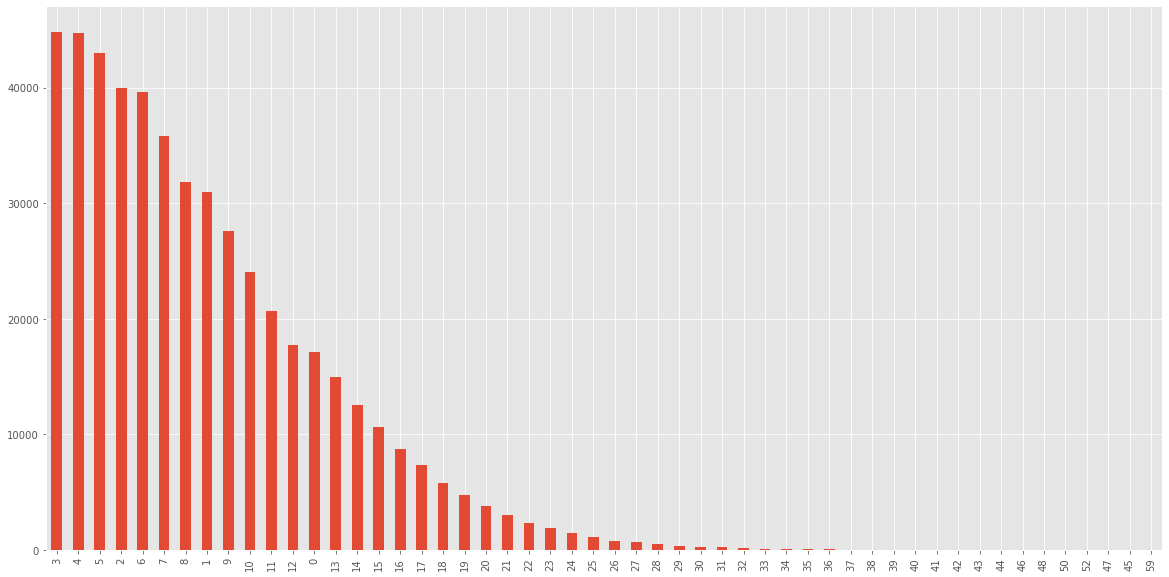

In [53]:
fig = plt.figure(figsize= (20,10))
df_players['kills'].value_counts().plot.bar()

Возьмём только тех героев, у которых было не менее 20 убийств

In [54]:
df_kills = df_players[df_players.kills >= 20]
df_kills

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,level
4,0,3,67,4,3307,23825,613,762,20,3,17,13,245,None,33740,243,1833,24
31,3,0,44,1,1145,18550,498,619,24,13,22,4,170,0.36778299999999997,27738,0,450,24
39,3,20,47,132,24,23505,500,631,20,11,19,14,166,None,27992,0,3241,25
61,6,32,8,1,674,24215,719,776,20,3,9,7,290,5.5189900000000005,22060,0,3671,22
102,10,53,44,2,6957,17325,917,871,24,1,3,11,224,13.5644,26143,0,3719,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499920,49992,0,13,0,1825,19985,504,615,27,10,16,2,161,47.4194,33844,0,1043,25
499929,49992,158347,8,132,6716,33215,734,638,26,8,11,14,310,31.343,30074,0,4309,25
499939,49993,0,100,132,3381,15190,533,627,22,9,13,1,102,42.2498,19491,0,26,22
499946,49994,0,32,129,1896,19925,543,747,27,8,17,0,51,0.33435499999999996,28060,0,4015,25


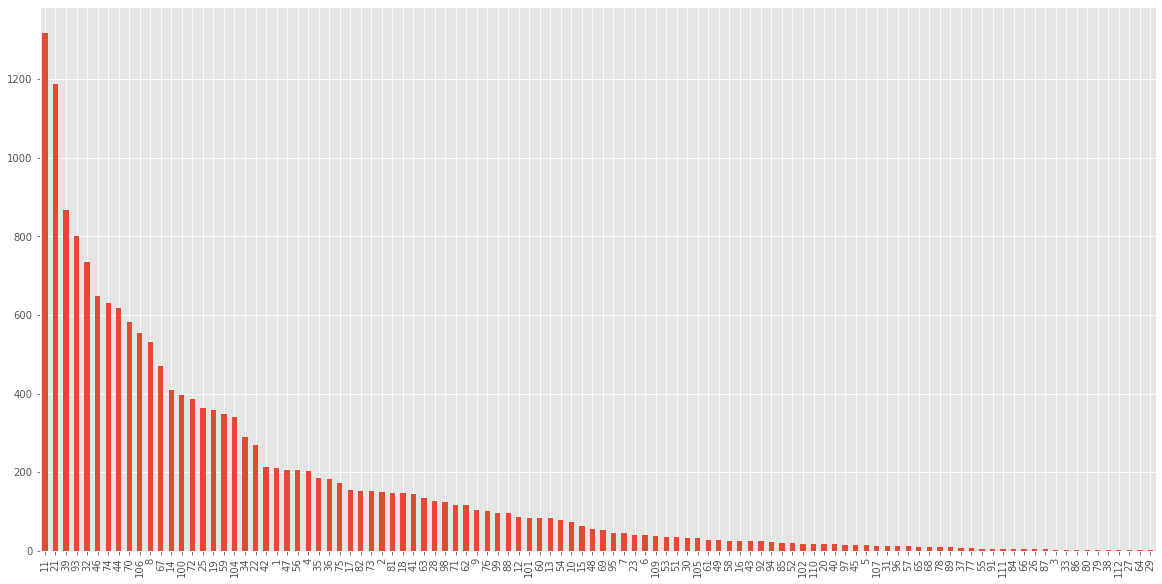

In [55]:
fig = plt.figure(figsize= (20,10))
df_kills['hero_id'].value_counts().plot.bar()

Выведем топ-5 героев, наиболее способных к убийству других персонажей и сноуболлу

In [56]:
df_top5kill_heroes = df_heroes[(df_heroes.hero_id == 11) | (df_heroes.hero_id == 21) | (df_heroes.hero_id == 39) |
         (df_heroes.hero_id == 93) | (df_heroes.hero_id == 32)]

In [57]:
df_top5kill_heroes

,hero_id,name
10,11,Shadow Fiend
20,21,Windranger
30,32,Riki
37,39,Queen of Pain
91,93,Slark


In [58]:
df_top5kill_heroes['toppick'] = [1,2,5,3,4]
df_top5kill_heroes = df_top5kill_heroes.sort_values(by = ['toppick'])
df_top5kill_heroes

,hero_id,name,toppick
10,11,Shadow Fiend,1
20,21,Windranger,2
37,39,Queen of Pain,3
91,93,Slark,4
30,32,Riki,5


Как мы видим, на момент 2015 года этими персонажами были сноуболлящие мидеры Shadow Fiend,  Windranger,
Queen of Pain и кэрри с большим приростом ловкости - Slark и Riki. Тоже вполне логично

# Проверка статистических гипотез

## Базовые исследования

Для начала проведём несколько лёгких исследований, не применяя статистические гипотезы напрямую.

Безусловно по ходу этого блока будут применены статистические гипотезы в различных исследованиях от 
менее сложных к более значимым. Но начнём с чего-то простого

In [216]:
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
from statsmodels.stats.descriptivestats import sign_test
import statsmodels.formula.api as smf

In [220]:
df_matches.duration.max()

16037

In [221]:
df_matches.duration.min()

59

Несмотря на то, что я написал, что в этом блоке не будет сначала прямого применения статистических гипотез,
без корреляции тут всё равно не обойтись.

Поэтому, сформулируем общую гипотезу корреляции применимую для любых двух признаков

H0: r = 0 - наши значения нескореллированы. Для Пирсона - нет линейной зависимости, для Спирмена - нет монотононой зависимости 

H1: r <> 0 - корреляция присутствует

#### Зависимость длительности матча от времени проливания первой крови( первое убийство в игре)

Проверим корреляцию длительности матча и первого убийства в игре

In [230]:
stats.pearsonr(df_matches.duration, df_matches.first_blood_time)

(0.022497744826538674, 4.875220009806186e-07)

In [231]:
stats.spearmanr(df_matches.duration, df_matches.first_blood_time)

SpearmanrResult(correlation=0.01336617354009768, pvalue=0.002800515273489721)

Как мы видим по результатам, мы не можем принять нулевую гипотезу.

Значит, между рассматриваемыми величинами присутствует некая линейная и монотонная зависимость

Попробуем построить линейную регрессию для этих величин и посмотреть, что же у нас получится

In [232]:
model = smf.ols('duration~first_blood_time',data=df_matches)
fitted = model.fit()

In [233]:
df_matches['predicted'] = fitted.params[0] + fitted.params[1]*df_matches['first_blood_time']

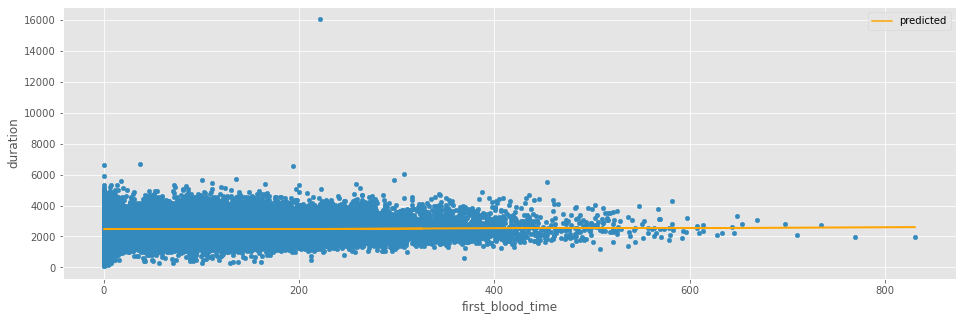

In [234]:
fig = plt.figure(figsize=(16,5))
ax1 = plt.subplot(111)

df_matches.plot.scatter('first_blood_time','duration',ax = ax1)
df_matches.plot.line('first_blood_time','predicted',ax = ax1,color = 'orange')

In [248]:
df_matches = df_matches.drop(['predicted'], axis = 1 )

Ну что могу сказать, в принципе, некоторая линейная зависимость прослеживается.
Но не сказал бы, что корректно говорить, что зависимость между ними линейная. Возможно, тут присутствует 
иная зависимость, нелинейная, которую получить при помощи регрессии довольно сложно.

#### Зависимость длительности матча от среднего заработанного золота всеми игроками в игре

Посчитаю среднее золото, заработанное всеми игроками за игру

In [237]:
avgold = np.zeros(50000, dtype = float)
for i in range (50000):
    avgold[i] = df_players[df_players.match_id == i].gold_spent.mean()

In [238]:
avgold = avgold.astype(int)

In [239]:
df_matches['avg_gold'] = avgold

Проверим корреляции

In [240]:
stats.pearsonr(df_matches.avg_gold,df_matches.duration)

(0.9449868626434036, 0.0)

In [241]:
stats.spearmanr(df_matches.avg_gold,df_matches.duration)

SpearmanrResult(correlation=0.9446698100445439, pvalue=0.0)

Как видно, pvalue = 0 => у нас должна присутствовать монотонная и линейная зависимость ( хоть какая-то).

Хотя, возможно, данные просто сильно разбросаны или не подходят под такой тест, не могу точно сказать

Построим линейную регрессию

In [244]:
model = smf.ols('duration~avg_gold',data=df_matches)
fitted = model.fit()

In [245]:
fitted.params

Intercept    174.260571
avg_gold       0.163163
dtype: float64

In [246]:
df_matches['predicted'] = fitted.params[0] + fitted.params[1]*df_matches['avg_gold']

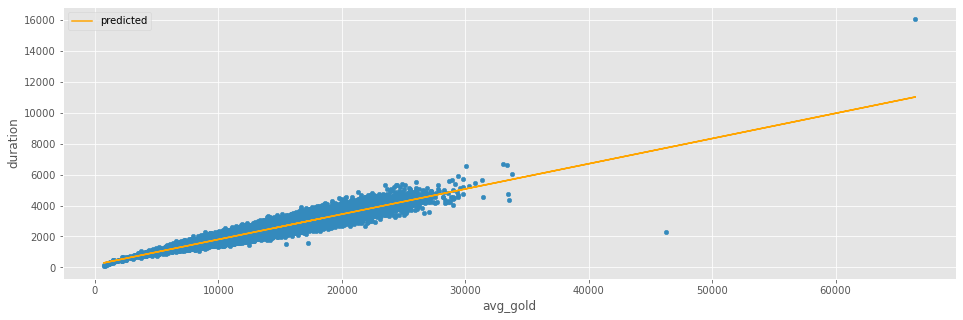

In [247]:
fig = plt.figure(figsize=(16,5))
ax1 = plt.subplot(111)

df_matches.plot.scatter('avg_gold','duration',ax = ax1)
df_matches.plot.line('avg_gold','predicted',ax = ax1,color = 'orange')

Выбросим два выброса, видимых на графике ( справа вверху и слева внизу) и построим регрессию заново

In [260]:
df_matches = df_matches[df_matches.duration <8000]
df_matches = df_matches[df_matches.avg_gold  < 35000]

In [261]:
model = smf.ols('duration~avg_gold',data=df_matches)
fitted = model.fit()

In [262]:
fitted.params

Intercept    176.126421
avg_gold       0.163031
dtype: float64

In [263]:
df_matches['predicted'] = fitted.params[0] + fitted.params[1]*df_matches['avg_gold']

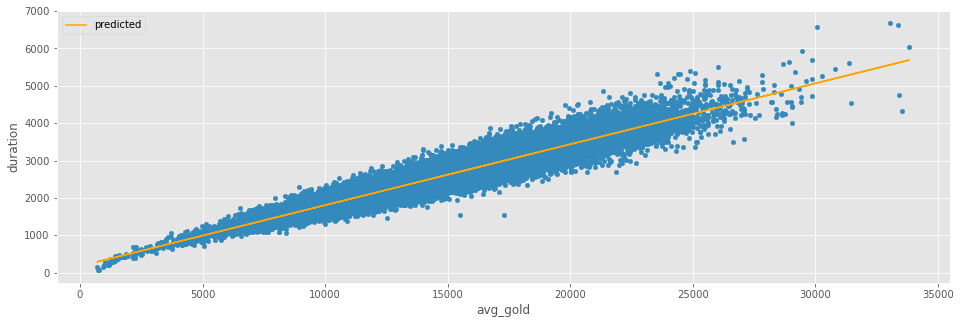

In [264]:
fig = plt.figure(figsize=(16,5))
ax1 = plt.subplot(111)

df_matches.plot.scatter('avg_gold','duration',ax = ax1)
df_matches.plot.line('avg_gold','predicted',ax = ax1,color = 'orange')

Как видно, действительно, некоторая зависимость прослеживается, должен признать

#### Зависимость скилла игрока от его винрейта ( отношения побед к общему числу матчей)

Определим винрейт игрока

In [278]:
df_playerMMR['winrate'] = df_playerMMR['total_wins']/df_playerMMR['total_matches']

In [279]:
df_playerMMR

,account_id,total_wins,total_matches,trueskill_mu,trueskill_sigma,winrate
0,236579,14,24,27.868035,5.212361,0.583333
5,308663,1,1,26.761476,8.108880,1.000000
6,79749,21,40,30.553417,3.868734,0.525000
9,26500,26,50,27.943621,4.049005,0.520000
11,137046,46,89,26.025998,2.865184,0.516854
...,...,...,...,...,...,...
834215,136022,1,2,24.065296,7.614250,0.500000
834218,215153,0,1,24.004033,8.150131,0.000000
834219,272061,0,1,22.214808,8.010834,0.000000
834222,106173,0,1,23.069381,7.998792,0.000000


Возьмём только тех игроков, кто наиграл больше 10 матчей

In [268]:
df_playerMMR10 = df_playerMMR[df_playerMMR.total_matches >10]
df_playerMMR10 

,account_id,total_wins,total_matches,trueskill_mu,trueskill_sigma,winrate
0,236579,14,24,27.868035,5.212361,0.583333
6,79749,21,40,30.553417,3.868734,0.525000
9,26500,26,50,27.943621,4.049005,0.520000
11,137046,46,89,26.025998,2.865184,0.516854
12,56881,15,23,32.856424,5.132469,0.652174
...,...,...,...,...,...,...
833771,109480,5,11,28.923031,5.669095,0.454545
833989,46098,13,23,24.633697,5.303516,0.565217
834032,18702,11,16,35.135201,5.058332,0.687500
834087,42556,3,12,19.065854,6.451897,0.250000


Проверим корреляции

In [269]:
stats.pearsonr(df_playerMMR10.trueskill_mu, df_playerMMR10.winrate)

(0.8521525586704811, 0.0)

In [270]:
stats.spearmanr(df_playerMMR10.trueskill_mu, df_playerMMR10.winrate)

SpearmanrResult(correlation=0.8404870142768934, pvalue=0.0)

Нулевая гипотеза отклоняется, значит наши величины скоррелированны. Построим регрессию

In [280]:
model = smf.ols('trueskill_mu~winrate',data=df_playerMMR10 )
fitted = model.fit()

In [281]:
fitted.params

Intercept    10.736075
winrate      29.353168
dtype: float64

In [282]:
df_playerMMR10['predicted'] = fitted.params[0] + fitted.params[1]*df_playerMMR10 ['winrate']

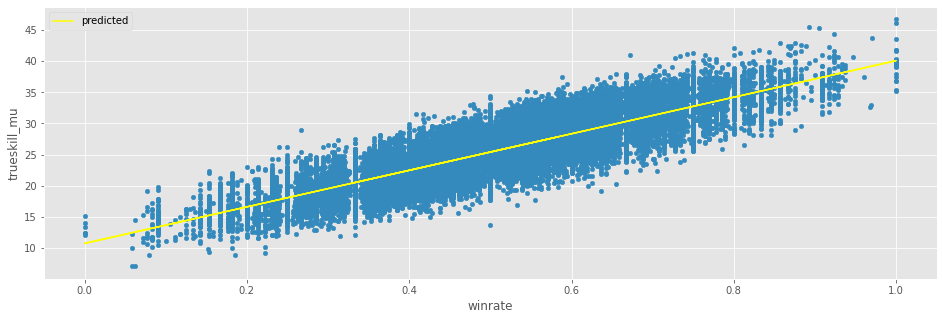

In [287]:
fig = plt.figure(figsize=(16,5))
ax1 = plt.subplot(111)

df_playerMMR10.plot.scatter('winrate','trueskill_mu',ax = ax1)
df_playerMMR10.plot.line('winrate','predicted',ax = ax1,color = 'yellow')

Как видно, зависимость действительно присутствует

## Параметические критерии

Какая первая идея - возьмём и посмотрим матчи в двух разных регионах - Европе и Америке.
Посчитаем их количество

In [288]:
df_regions.head(16)

,cluster,region
0,111,US WEST
1,112,US WEST
2,113,US WEST
3,121,US EAST
4,122,US EAST
5,123,US EAST
6,124,US EAST
7,131,EUROPE
8,132,EUROPE
9,133,EUROPE


In [289]:
df_europe = df_matches.loc[(df_matches['cluster'] >=131) & (df_matches['cluster'] <= 138)]
df_europe

,match_id,start_time,duration,first_blood_time,radiant_win,negative_votes,positive_votes,cluster,avg_gold,predicted
2,2,1446764586,2716,190,False,0,0,132,13661,2403.294236
7,7,1446804030,2328,255,True,0,0,138,14439,2530.132430
9,9,1446837251,2961,85,False,0,0,133,15070,2633.005052
10,10,1446839926,1562,143,True,0,0,133,8060,1490.157062
12,12,1446853394,3995,3,False,0,0,138,24678,4199.407832
...,...,...,...,...,...,...,...,...,...,...
49951,49951,1447828538,3910,78,False,0,0,133,21249,3640.374200
49953,49953,1447828545,1445,113,False,0,0,132,8915,1629.548650
49966,49966,1447828796,2465,94,True,0,0,138,16592,2881.138382
49976,49976,1447828908,1433,104,False,0,0,132,7483,1396.088119


In [290]:
df_america = df_matches.loc[(df_matches['cluster'] == 111) | (df_matches['cluster'] == 112) | (df_matches['cluster'] == 113)
                           | (df_matches['cluster'] == 121) | (df_matches['cluster'] == 122) | (df_matches['cluster'] == 123)
                           | (df_matches['cluster'] == 124)]
df_america

,match_id,start_time,duration,first_blood_time,radiant_win,negative_votes,positive_votes,cluster,avg_gold,predicted
11,11,1446850598,3280,76,False,0,0,122,19813,3406.261545
13,13,1446855028,2452,120,True,0,0,123,13335,2350.146099
15,15,1446858132,3122,101,False,0,0,121,17629,3050.201629
16,16,1446860653,3318,252,False,0,0,121,18754,3233.611613
17,17,1446861016,3798,4,True,0,2,123,21974,3758.571745
...,...,...,...,...,...,...,...,...,...,...
49989,49989,1447829126,1556,223,False,0,0,121,8725,1598.572742
49990,49990,1447829137,3580,5,True,0,0,111,22636,3866.498332
49991,49991,1447829136,2883,62,True,0,0,123,16571,2877.714729
49995,49995,1447829192,3025,117,True,0,0,111,16797,2914.559756


Мы получили матчи, сыгранные на серверах европы и америки соответственноо

А теперь возьмём те матчи, которые можно посчитать короткими,а именно - матчи, которые длились не более 30 минут и 
посмотрим сколько у нас их

In [291]:
df_europeshortmatches = df_europe[df_europe.duration < 1800]
df_europeshortmatches .shape

(2545, 10)

In [292]:
df_americashortmatches = df_america[df_america.duration < 1800]
df_americashortmatches.shape

(1906, 10)

In [293]:
df_europe.shape

(18447, 10)

In [294]:
df_america.shape

(14678, 10)

Мы подготовили всё необходимое для того, чтобы воспользоваться Z-критерием для несвязанных выборок.

Сформулируем гипотезу

H0: Доля коротких матчей для Америки и Европы одинакова

H1: доля  коротких матчей в Европе больше, чем в Америке ('smaller')

In [296]:
americashort = np.array([1906,14678])
europeshort = np.array([2545,18447])
proportions_ztest(americashort, europeshort, alternative='smaller')

(-5.429923165557677, 2.818915963889386e-08)

Как мы видим, нулевая гипотеза отвергается и мы вынуждены признать, что в Европе коротких матчей больше, чем в Америке

А теперь вопрос. Что нам мешает воспользоваться также критерием Хи-квадрат? Он тоже подойдёт

Давайте воспользуемся им и посмотрим, что же у нас получится в данном случае. Будет ли тот же результат, как и в 
случае Z- критерия?

Гипотезы будут те же самые. Одинаковая ли доля коротких матчей в Америке и Европе?

In [297]:
shortdata = pd.DataFrame()
shortdata['europe'] = [2545,15902,18447]
shortdata['america'] = [1906, 12772,14678]
shortdata.index = ['shorter than 30 minutes', 'longer than 30 minutes','Всего']
shortdata['Total'] = shortdata['europe'] + shortdata['america']
shortdata

,europe,america,Total
shorter than 30 minutes,2545,1906,4451
longer than 30 minutes,15902,12772,28674
Всего,18447,14678,33125


In [300]:
chi2, p, dof, ex = chi2_contingency(shortdata.iloc[:2,:2])
chi2,p,dof,ex

(4.55111792433831,
 0.03289726074475275,
 1,
 array([[ 2478.71990943,  1972.28009057],
        [15968.28009057, 12705.71990943]]))

Как мы видим, установив стандартный  уровень значимости  в 5% мы получаем,что результаты, полученные 
Z-критерием и критерием Хи-квадрат полностью совпадают

Одно исследование? Мало, давайте проверим то же самое, но для матчей, которые длились более 50 минут.

Аналогично посчитаем части, которые отвечают за длинные матчи в Америке и Европе

In [309]:
df_europelongmatches = df_europe[df_europe.duration > 3000]
df_europelongmatches.shape

(3543, 10)

In [310]:
df_americalongmatches = df_america[df_america.duration > 3000]
df_americalongmatches.shape

(2875, 10)

In [311]:
df_europe.shape

(18447, 10)

In [312]:
df_america.shape

(14678, 10)

In [315]:
americalong = ([2875,14678])
europelong = ([3543,18447])

In [316]:
proportions_ztest(americalong, europelong, alternative='smaller')

(2.1428423607055818, 0.9839371207195912)

А вот в этом случае, Z-критерий говорит, что количество долгих матчей в Америке и Европе - одинаковое количество.

Проверим также Хи-квадрат

In [317]:
longdata = pd.DataFrame()
longdata['europe'] = [3543,14904,18447]
longdata['america'] = [2875, 11803,14678]
longdata.index = ['longer than 50 minutes', 'shorter than 50 minutes','Всего']
longdata['Total'] = longdata['europe'] + longdata['america']
longdata

,europe,america,Total
longer than 50 minutes,3543,2875,6418
shorter than 50 minutes,14904,11803,26707
Всего,18447,14678,33125


In [318]:
chi2, p, dof, ex = chi2_contingency(longdata.iloc[:2,:2])
chi2,p,dof,ex

(0.7344533158436484,
 0.39144349303552384,
 1,
 array([[ 3574.12365283,  2843.87634717],
        [14872.87634717, 11834.12365283]]))

Как мы видим, Хи-квадрат также даёт нам ответ, что доли длительных игр в Европе и Америке одинаковы. Отлично

Произведём ещё одно третье исследование на параметрический критерий, а именно Z-критерий.

В моём понимании, как уже отмечалось, короткие матчи - это матчи, которые длились не более 30 минут,а длинные матчи - 
это матчи, которые длились не менее 50 минут.

Сформулируем нулевую гипотезу и альтернативную:
    
Н0: доля побед сил света для коротких матчей точно такая же, как и доля побед для длинных матчей

H1: доля побед сил света в длинных матчах больше, чем доля побед сил света в коротких матчах среди рассматриваемых

In [319]:
df_shortmatches = df_matches[df_matches.duration <= 1800]
df_shortmatches.shape

(6567, 10)

In [320]:
df_longmatches = df_matches[df_matches.duration >= 3000]
df_longmatches.shape

(9645, 10)

In [321]:
df_shortmatches_radiant = df_shortmatches[df_shortmatches.radiant_win == True]
df_shortmatches_radiant.shape

(4013, 10)

In [322]:
df_shortmatches_dire = df_shortmatches[df_shortmatches.radiant_win == False]
df_shortmatches_dire.shape

(2554, 10)

In [323]:
df_longmatches_radiant = df_longmatches[df_longmatches.radiant_win == True]
df_longmatches_radiant.shape

(4602, 10)

In [324]:
df_longmatches_dire = df_longmatches[df_longmatches.radiant_win == False]
df_longmatches_dire.shape

(5043, 10)

Проверим Z-критерий

In [329]:
radiant_win1 = np.array([4013, 6567])
radiant_win2 = np.array([4602, 9646])
proportions_ztest(radiant_win1, radiant_win2,alternative = 'smaller')

(24.410752385830442, 1.0)

p-value = 1. Что же это значит? По идее, это значит, что доля побед сил света в длинных матчах точно не больше,
чем доля побед в коротких. И хотелось бы сказать, что мы должны принять нулевую гипотезу о равенстве.

Но почему-бы нам не проверить ещё two-sided и larger альтернативы?

In [330]:
radiant_win1 = np.array([4013, 6567])
radiant_win2 = np.array([4602, 9646])
proportions_ztest(radiant_win1, radiant_win2, alternative='two-sided')

(24.410752385830442, 1.3148793443705078e-131)

In [331]:
radiant_win1 = np.array([4013, 6567])
radiant_win2 = np.array([4602, 9646])
proportions_ztest(radiant_win1, radiant_win2, alternative='larger')

(24.410752385830442, 6.574396721852539e-132)

Как мы видим, оказывается, доля побед сил света в коротких матчах всё-таки больше. Либо же это просто ситуация данного датасета
и по идее разницы в стороне глобально не должно быть. Либо же, если задуматься, в доте светлая сторона в 2015 году уже 
точно имела большее преимущество,в силу того, что им было удобнее контролировать и заходить на Рошана. Поэтому, возможно
это действительно правда

## Непараметрические критерии

Проведём несколько тестов при помощи непараметрических критериев, не привязанных к параметрам распределения

In [332]:
df_matches.first_blood_time.max()

831

In [333]:
df_matches.first_blood_time.min()

0

В нашем датасете матчей присутствуют матчи с совершенно разным временем пролития первой крови. 

Что если мы сравним матчи, в которых первая кровь пролилась ОЧЕНЬ быстро, в течение первой минуты и, наоборот,
матчи,в которых первая кровь пролилась совсем поздно. 

Совсем поздно - понятие растяжимое, но давайте для объективности
(в силу того, что чем позже пролилась первая кровь , тем меньше матчей мы имеем) возьмём матчи с поздней первой кровью - 
это те матчи, первая кровь в которых пролилась позже пятой минуты

In [336]:
df_fastFB = df_matches.loc[(df_matches['first_blood_time'] >= 0 ) & (df_matches['first_blood_time'] <= 60)]
df_fastFB.shape

(22164, 10)

In [340]:
df_fastFB = df_fastFB.sort_values(by=['first_blood_time'], ascending=[True])
df_fastFB

,match_id,start_time,duration,first_blood_time,radiant_win,negative_votes,positive_votes,cluster,avg_gold,predicted
49993,49993,1447829156,2410,0,False,0,0,154,14908,2606.594014
24918,24918,1447576116,3526,0,True,0,0,155,19784,3401.533643
7141,7141,1447385496,1648,0,False,0,0,123,9353,1700.956271
7144,7144,1447385558,2557,0,True,0,0,123,18205,3144.107541
24893,24893,1447575858,3023,0,False,0,0,132,18873,3253.012314
...,...,...,...,...,...,...,...,...,...,...
8414,8414,1447405646,1322,60,True,0,0,185,7045,1324.680499
26890,26890,1447595341,1764,60,True,0,0,132,11208,2003.378956
6530,6530,1447378626,3717,60,False,0,0,171,22466,3838.783045
32000,32000,1447629698,2320,60,False,0,0,132,14734,2578.226603


Визуализируем данные

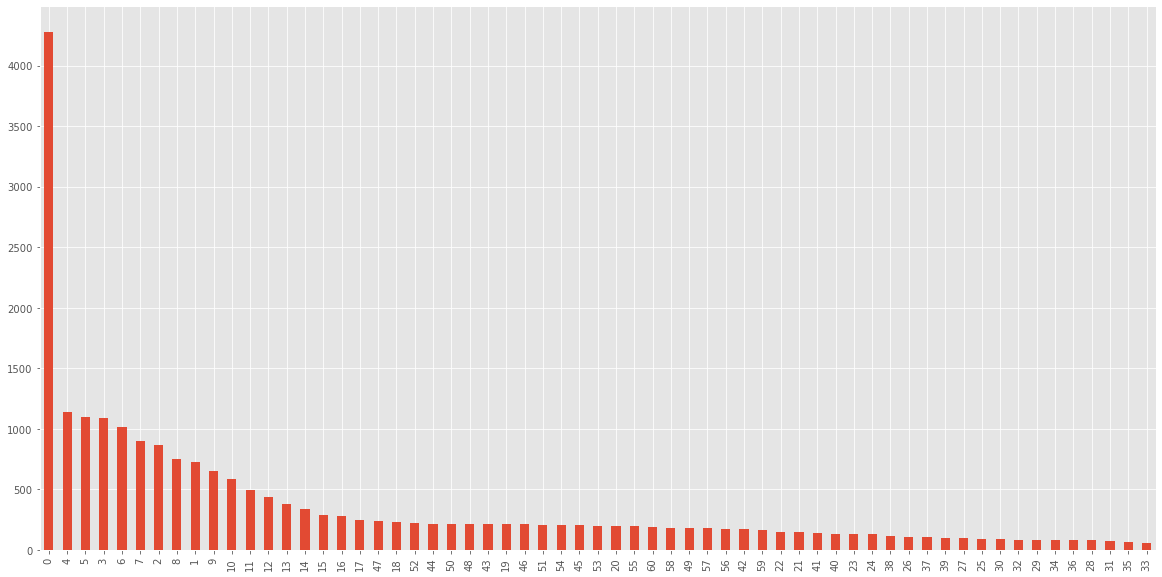

In [343]:
fig = plt.figure(figsize= (20,10))
df_fastFB['first_blood_time'].value_counts(sort = True).plot.bar()

In [ ]:
Как мы видим, чем позже была пролита первая кровь, тем меньше матчей мы имеем.

In [345]:
df_lateFB = df_matches.loc[(df_matches['first_blood_time'] >= 300)]
df_lateFB.shape

(1702, 10)

А теперь, попробуем понять взаимосвязь между длительностью игры и временем первого убийства на карте

Логично предположить, что если в игре первая кровь проливается поздно, то это должно означать, что игра будет долгой.
Ведь всё идёт довольно медленно, фрагов не происходит и скорее всего, это затянется.

Или же средняя длительность игры в матчах, где первая кровь была пролита поздно и в матчах, где
первая кровь была пролита в течение первой минуты или ещё до начала матча одинаковая?

Проверим это при помощи одновыборочного знаков рангов Уилкоксона.
Сформулируем гипотезы

H0: среднее время игры с ранней первой кровью совпадает со средним временем игры с поздней первой кровью

H1: есть отличия( неважно в какую сторону)

Переведём длительность в массивы

In [348]:
fastFBarray = np.array( df_fastFB.duration )
fastFBarray

array([2410, 3526, 1648, ..., 3717, 2320, 2256], dtype=int64)

In [349]:
lateFBarray = np.array( df_lateFB.duration )
lateFBarray

array([1351, 2959, 1947, ..., 2713, 1934, 1993], dtype=int64)

In [350]:
print( fastFBarray.shape[0], lateFBarray.shape[0])

22164 1702


Посчитаем среднее для игр с поздним первым убийством и применим критерий для выборки с ранними первыми убийствами

In [351]:
lateFBarray.mean()

2560.9359576968272

In [352]:
stats.wilcoxon(lateFBarray - 2472.0727305540518)

WilcoxonResult(statistic=659841.0, pvalue=0.0013994860882030446)

А теперь посчитаем и применим наоборот

In [353]:
fastFBarray.mean()

2472.0727305540518

In [354]:
stats.wilcoxon(fastFBarray - 2560.9359576968272)

WilcoxonResult(statistic=98260603.0, pvalue=1.550426776723999e-146)

Как мы видим, действительно, мы не можем принять нулевую гипотезу о равенстве средней длительности игр,
из чего можно сделать вполне резонный вывод о том, что средняя длительность в таких матчах отличается, -
скорее всего игры с поздним первым убийством длятся дольше

В предыдущем примере нам было сложно оперировать двухвыборочными критериями.

Во-первых, наши выборки были никак не связаны. Во-вторых, они имели существенно разную по числовому значению размерность:

~20000 одной выборки к 2000 другой выборки 

Для полного применения непараметрических критериев, я возьму случай,в котором уместно будет применить непараметрический
критерий знаков Уилкоксона, но для двух СВЯЗАННЫХ выборок

При этом, наши выборки должны быть одинаковой размерности

В пункте выше "Визуализация данных" я приводил визуализацию пикабельности героев. Я нашёл примерно одинаково пикабельных
героев, но при этом сильно различных

Рассмотрим hero_id равные 34 и 6 и посмотрим, какое количество матчей у нас есть для этих героев

In [361]:
df_players[df_players.hero_id == 34].shape

(2610, 18)

In [360]:
df_players[df_players.hero_id == 6].shape

(2608, 18)

Как мы видим, размеры выборок для этих героев - 2610 и 2608. Но что же это за герои такие, которых я выбрал?

In [362]:
df_heroes[df_heroes.hero_id == 6]

,hero_id,name
5,6,Drow Ranger


In [363]:
df_heroes[df_heroes.hero_id == 34]

,hero_id,name
32,34,Tinker


Как видно, первый герой с индексом 34 - это тинкер. Тинкер - это персонаж, из-за которого порой в игре действительно
сложно зайти на базу противника и сломать её. 

Следовательно что? Следовательно, наличие этого персонажа в игре потенциально
затрудняет быстрое окончание игры и затягивает её ( благо к 2015 году выпущенного в 2014 году минёра ещё не добавили
   в рейтинговый режим).

Второй герой - drow ranger. Этот герой ( по другому ещё тракса) имеет большой пуш-потенциал и зачастую в 2015 году и ранее
многие игры заканчивались довольно рано просто потому, что наличие этого героя в игре давало возможность быстро
снести противника при удачном раскладе early и pre-mid гейма.

А это значит, что длительность игр с наличием траксы должна быть наоборот короче, чем с тинкером.

Это мы и проверим при помощи критерия.

Сформулируем нулевую и альтернативные гипотезы:
    
H0: Длительности игр в матчах с Тинкером и Траксой одинаковы

H1: Длительности игр отличаются ( неважно в какую сторону)

 Для полного эффекта удалю две строчки из датасета для героя с индексом 34, чтобы размерности выборок стали одинаковыми

In [364]:
tinker = df_players[df_players.hero_id == 34]
tinker = tinker.drop(index=[499934,499741])
tinker

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,level
154,15,0,34,4,1311,18820,514,622,16,14,13,11,241,None,26112,0,386,25
178,17,0,34,131,2914,21470,437,516,16,8,28,4,224,None,30328,0,78,25
197,19,111,34,130,24,8245,242,219,0,7,5,3,128,None,3136,0,18,11
323,32,182,34,3,3428,15845,641,688,7,2,8,14,233,None,14735,413,137,19
696,69,0,34,129,1275,25070,585,601,10,9,8,5,375,None,20310,42,11,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498838,49883,0,34,131,1404,14145,333,382,0,7,5,2,157,None,7904,0,168,19
499148,49914,0,34,131,1816,23275,500,538,17,12,18,5,280,None,31403,0,0,25
499448,49944,0,34,131,1612,10695,345,379,9,12,11,9,129,None,18265,0,116,18
499567,49956,0,34,130,6299,13890,293,438,5,3,9,4,99,None,13339,0,319,19


In [365]:
drow_ranger = df_players[df_players.hero_id == 6]
drow_ranger

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,level
135,13,75,6,128,1160,11800,340,338,4,5,6,2,131,0.200615,7503,0,1733,16
306,30,0,6,129,154,10610,278,378,6,7,4,6,91,None,6361,0,598,17
784,78,447,6,4,1592,20415,383,510,8,12,12,4,261,None,15090,0,1618,25
863,86,0,6,3,3713,14760,682,615,7,3,2,2,144,None,10264,0,5750,16
910,91,514,6,0,2029,20395,452,593,7,7,5,2,182,None,10056,0,1078,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498937,49893,158131,6,130,5290,10675,526,506,2,3,6,9,137,None,4447,0,4588,16
499236,49923,0,6,129,1902,16595,457,404,8,3,7,1,127,None,10349,0,7821,17
499549,49954,0,6,132,6016,13735,532,549,13,7,12,4,133,None,13174,0,6082,20
499622,49962,1860,6,2,271,8070,272,280,1,10,4,10,89,None,5673,0,190,13


Почему выборки являются связанными? Да просто потому, что среди этих матчей естественно могли оказаться матчи,
 в которых игроками одновременно были выбраны Тинкер и Тракса

Перейдём в таблицу с матчами при помощи индексов

In [366]:
tinkid = tinker.match_id.unique()
tinkid

array([   15,    17,    19, ..., 49944, 49956, 49957], dtype=int64)

In [367]:
drowid = drow_ranger.match_id.unique()
drowid

array([   13,    30,    78, ..., 49954, 49962, 49993], dtype=int64)

Найдём пересечения по индексам матчей для тинкера и траксы

In [368]:
reslist = (set(tinkid) & set (drowid))
reslist = list( reslist )
reslist = np.array(reslist)
reslist.shape

(118,)

Как мы видим, выборки действительно являются связанными - 118 общих матчей для обоих героев

In [369]:
tinker_matches = df_matches[df_matches['match_id'].isin(tinkid)]
tinker_matches

,match_id,start_time,duration,first_blood_time,radiant_win,negative_votes,positive_votes,cluster,avg_gold,predicted
15,15,1446858132,3122,101,False,0,0,121,17629,3050.201629
17,17,1446861016,3798,4,True,0,2,123,21974,3758.571745
19,19,1446870404,2234,112,True,0,0,184,14680,2569.422924
32,32,1446917368,1749,4,True,0,0,155,9864,1784.265161
69,69,1447009624,2850,43,True,0,0,133,16743,2905.756077
...,...,...,...,...,...,...,...,...,...,...
49883,49883,1447827515,3001,153,False,0,0,121,16894,2930.373773
49914,49914,1447827842,3670,135,True,0,0,151,20000,3436.748360
49944,49944,1447828362,2741,167,True,0,0,154,15139,2644.254198
49956,49956,1447828566,2752,204,True,0,0,171,14350,2515.622662


In [370]:
drow_matches = df_matches[df_matches['match_id'].isin(drowid)]
drow_matches

,match_id,start_time,duration,first_blood_time,radiant_win,negative_votes,positive_votes,cluster,avg_gold,predicted
13,13,1446855028,2452,120,True,0,0,123,13335,2350.146099
30,30,1446910754,2420,2,True,0,1,133,12282,2178.474354
78,78,1447033049,3808,110,False,1,1,121,19480,3351.972190
86,86,1447043739,1458,76,True,0,0,123,9897,1789.645187
91,91,1447059448,2810,26,False,0,0,123,16271,2828.805399
...,...,...,...,...,...,...,...,...,...,...
49893,49893,1447827666,1668,0,False,0,0,154,9658,1750.680755
49923,49923,1447827987,2402,234,False,0,0,111,14172,2486.603127
49954,49954,1447828540,2287,21,False,0,0,122,14012,2460.518151
49962,49962,1447828674,1983,46,False,0,0,122,10806,1937.840455


А теперь ничего не мешает нам применить критерий для длительности матчей

In [371]:
stats.wilcoxon(np.array(tinker_matches.duration),np.array(drow_matches.duration))

WilcoxonResult(statistic=1335685.5, pvalue=2.741026615270882e-21)

Как мы видим, p-value чрезмерно маленький,а это значит, что мы вынуждены отклонить нулевую гипотезу в пользу альтернативной.

Таким образом, длительности матчей с этими двумя героями отличаются - скорее всего, матчи с тинкером имеют
большую длительность из-за его потенциала затягивать игры. По крайней мере на момент 2015 года

# Выводы о проделаннном исследовании

Я исследовал датасет по игре Дота 2

Для начала,я визуализировал данные и проверил несколько интересных закономерностей. Во-первых,я посмотрел топ-10
самых пикабельных и антипикабельных героев в 50 тысячах матчей. Затем, я сделал тоже самое, но уже для других
100 тысяч матчей и сравнил результаты. В большинстве своём они подтвердились, что обозначает, что полученный мною топ-10 героев
для каждого из случаев действительно были популярными и антипопулярными на ноябрь 2015 года

Затем я проверил топ-5 персонажей, которые убивали чаще всего и топ-5 персонажей, которых наоборот чаще всего убивали

Далее,перед проверкой гипотез, я проверил при помощи корреляции Пирсона и Спирмена три зависимости:

1) Зависимость длительности матча от времени проливания первой крови( первое убийство в игре)

2) Зависимость длительности матча от среднего заработанного золота всеми игроками в игре 

3) Зависимость скилла игрока от его винрейта ( отношения побед к общему числу матчей)

Все эти зависимости присутствовали и тесты показали, что между этими величинами есть монотонные и линейные корреляции.

В связи с чем,в дальнейшем я построил и визуализировал линейную регрессию в каждом из случаев.

Перейдя к гипотезам, при помощи параметрических критериев Z-критерия и критерия Хи-квадрат я проверил в каком же регионе - в Америке или Европе самые длинные и самые короткие матчи. Оба критерия дали один и тот же результат.

Напоследок в блоке параметрических критериев при помощи Z-критерия я проверил зависимость того, какая сторона чаще
выигрывает в зависимости от длительности матча. Результат получился немного странным, ибо я ожидал, что никакая сторона
не будет иметь преимущества и доля побед сил света для коротких и длинных матчей будет одинакова, что автоматически будет 
означать, что и доля побед сил тьмы будет одинаковой, а это значит, что неважно за какую сторону играет команда.

Однако же, результат получился такой, что в коротких матчах команда сил света побеждала чаще.

Напоследок,я использовал непараметрический критерий знаков Уилкоксона в двух случаях:

1) Во-первых, для того, чтобы проверить зависимость средней длительности игры от времени проливания первой крови ( сделанного
первого убийства в игре). Это дало результат о том, что средняя длительность игры отличается в играх с быстрым первым убийством и наоборот,с поздним.

2) Во-вторых, я рассмотрел двух героев,на которых игроки сыграли одинаковое число матчей. Один из них имеет сильный потенциал к быстрому окончанию игры, другой же - наоборот к затягиванию.
В результате применения критерия, я получил что длительности таких игр действительно различаются. Скорее всего, с тем героем, у которого есть потенциал затягивать игры длительности игр как раз таки и больше

# Post scriptum

Мне очень понравилось проводить данные исследования в рамках этого мини-проекта. Я понимаю, что я не использовал нигде
временные ряды, однако же, я постарался сделать эту работу максимально объемно и качественно. 

Большое спасибо техносфере за такую возможность